# CMB simulation and gradient rotation example: T/Q/U

In [16]:
data_folder = '/Users/sraghunathan/Research/SPTPol/analysis/git/cmb_cluster_lensing/python/data/'
sys_path_folder = '/Users/sraghunathan/Research/SPTPol/analysis/git/cmb_cluster_lensing/python/'

In [17]:
import numpy as np, sys, os, scipy as sc
sys.path.append(sys_path_folder)
import flatsky, tools

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
rcParams['figure.dpi'] = 150

In [19]:
#params or supply a params file
dx = 1.0
boxsize_am = 120. #boxsize in arcmins
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx
verbose = 0
pol = True
debug = True
#beam and noise levels
noiseval = 5. #uK-arcmin
if pol:
    noiseval = [noiseval, noiseval * np.sqrt(2.), noiseval * np.sqrt(2.)]
beamval = 1.2 #arcmins

#CMB power spectrum
Cls_file = '%s/camb/planck18_TTEEEE_lowl_lowE_lensing_highacc/planck2018_base_plikHM_TTTEEE_lowl_lowE_lensing_lensedCls.dat' %(data_folder)

#cluster info
total_clusters = 500

if not pol:
    tqulen = 1
else:
    tqulen = 3
tqu_tit_arr = ['T', 'Q', 'U']

    
#cutouts specs 
cutout_size_am = 10. #arcmins

# for estimating cmb gradient
apply_wiener_filter = True
lpf_gradient_filter = 2000.
cutout_size_am_for_grad = 6.0 #arcminutes

In [20]:
#get ra, dec or map-pixel grid
ra = np.linspace(x1,x2, nx) #arcmins
dec = np.linspace(x1,x2, nx) #arcmins
ra_grid, dec_grid = np.meshgrid(ra,dec)

In [21]:
def dl_to_cl(el, cl_or_dl, inverse = 0):
    dl_fac = (el * (el+1)/2./np.pi)
    if inverse:
        return cl_or_dl*dl_fac
    else:
        return cl_or_dl/dl_fac

In [22]:
#read Cls now
el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(Cls_file, unpack = 1)
dl_all = np.asarray( [dl_tt, dl_ee, dl_bb, dl_te] )
cl_all = dl_to_cl(el, dl_all)
cl_tt, cl_ee, cl_bb, cl_te = cl_all #Cls in uK
cl_dic = {}
cl_dic['TT'], cl_dic['EE'], cl_dic['BB'], cl_dic['TE'] = cl_tt, cl_ee, cl_bb, cl_te
if not pol:
    cl = [cl_tt]    
else:
    cl = cl_all
#loglog(el, cl_tt)
print(len(el))

19899


In [23]:
#get beam and noise
bl = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)
nl_dic = {}
if pol:
    nl = []
    for n in noiseval:
        nl.append( tools.get_nl(n, el) )
    nl = np.asarray( nl )
    nl_dic['T'], nl_dic['P'] = nl[0], nl[1]
else:
    nl = [tools.get_nl(noiseval, el)]
    nl_dic['T'] = nl[0]
print(nl_dic)

{'T': array([2.11539875e-06, 2.11539875e-06, 2.11539875e-06, ...,
       2.11539875e-06, 2.11539875e-06, 2.11539875e-06]), 'P': array([4.2307975e-06, 4.2307975e-06, 4.2307975e-06, ..., 4.2307975e-06,
       4.2307975e-06, 4.2307975e-06])}


Text(0.5, 0, 'Multipole $\\ell$')

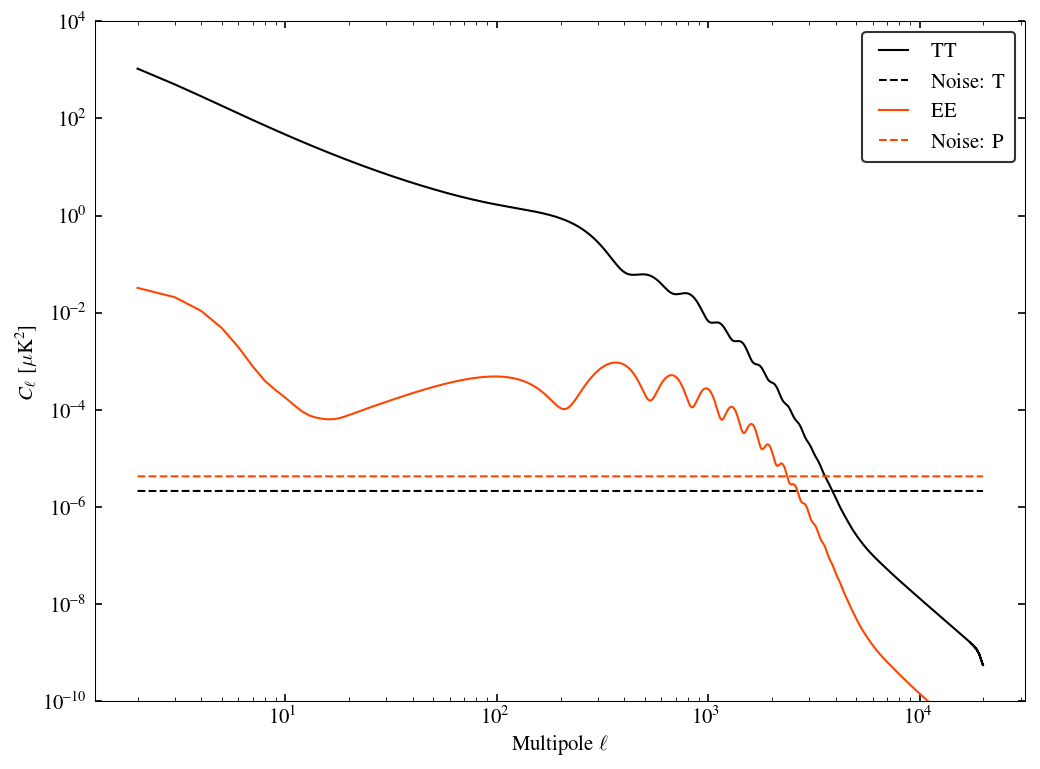

In [24]:
#plot
figure(figsize=(8,6))
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl[0], color = 'black', label = r'TT')
plot(el, nl[0], color = 'black', ls ='--', label = r'Noise: T')
if pol:
    plot(el, cl[1], color = 'orangered', label = r'EE')
    plot(el, nl[1], color = 'orangered', ls ='--', label = r'Noise: P')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$ [$\mu$K$^{2}$]')
xlabel(r'Multipole $\ell$')

In [25]:
#perform CMB and noise simulations
sim_arr = []
for i in tqdm(range(total_clusters)):
    if not pol:
        cmb_map = np.asarray( [flatsky.make_gaussian_realisation(mapparams, el, cl[0], bl = bl)] )
        noise_map = np.asarray( [flatsky.make_gaussian_realisation(mapparams, el, nl[0])] )
    else:
        cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl[0], cl2 = cl[1], cl12 = cl[3], bl = bl, qu_or_eb = 'qu')
        noise_map_T = flatsky.make_gaussian_realisation(mapparams, el, nl[0])
        noise_map_Q = flatsky.make_gaussian_realisation(mapparams, el, nl[1])
        noise_map_U = flatsky.make_gaussian_realisation(mapparams, el, nl[1])
        noise_map = np.asarray( [noise_map_T, noise_map_Q, noise_map_U] )
    sim_map = cmb_map + noise_map
    sim_arr.append( sim_map )

  0%|          | 0/500 [00:00<?, ?it/s]/Users/sraghunathan/Research/SPTPol/analysis/git/cmb_cluster_lensing/python/flatsky.py:276: RuntimeWarning: invalid value encountered in true_divide
  t1 = np.copy( gauss_reals_1_fft ) * cltwod12 / np.copy(cltwod)**0.5
/Users/sraghunathan/Research/SPTPol/analysis/git/cmb_cluster_lensing/python/flatsky.py:277: RuntimeWarning: invalid value encountered in true_divide
  t2 = np.copy( gauss_reals_2_fft ) * ( cltwod2 - (cltwod12**2. /np.copy(cltwod)) )**0.5
100%|██████████| 500/500 [00:15<00:00, 31.75it/s]


<Figure size 900x600 with 0 Axes>

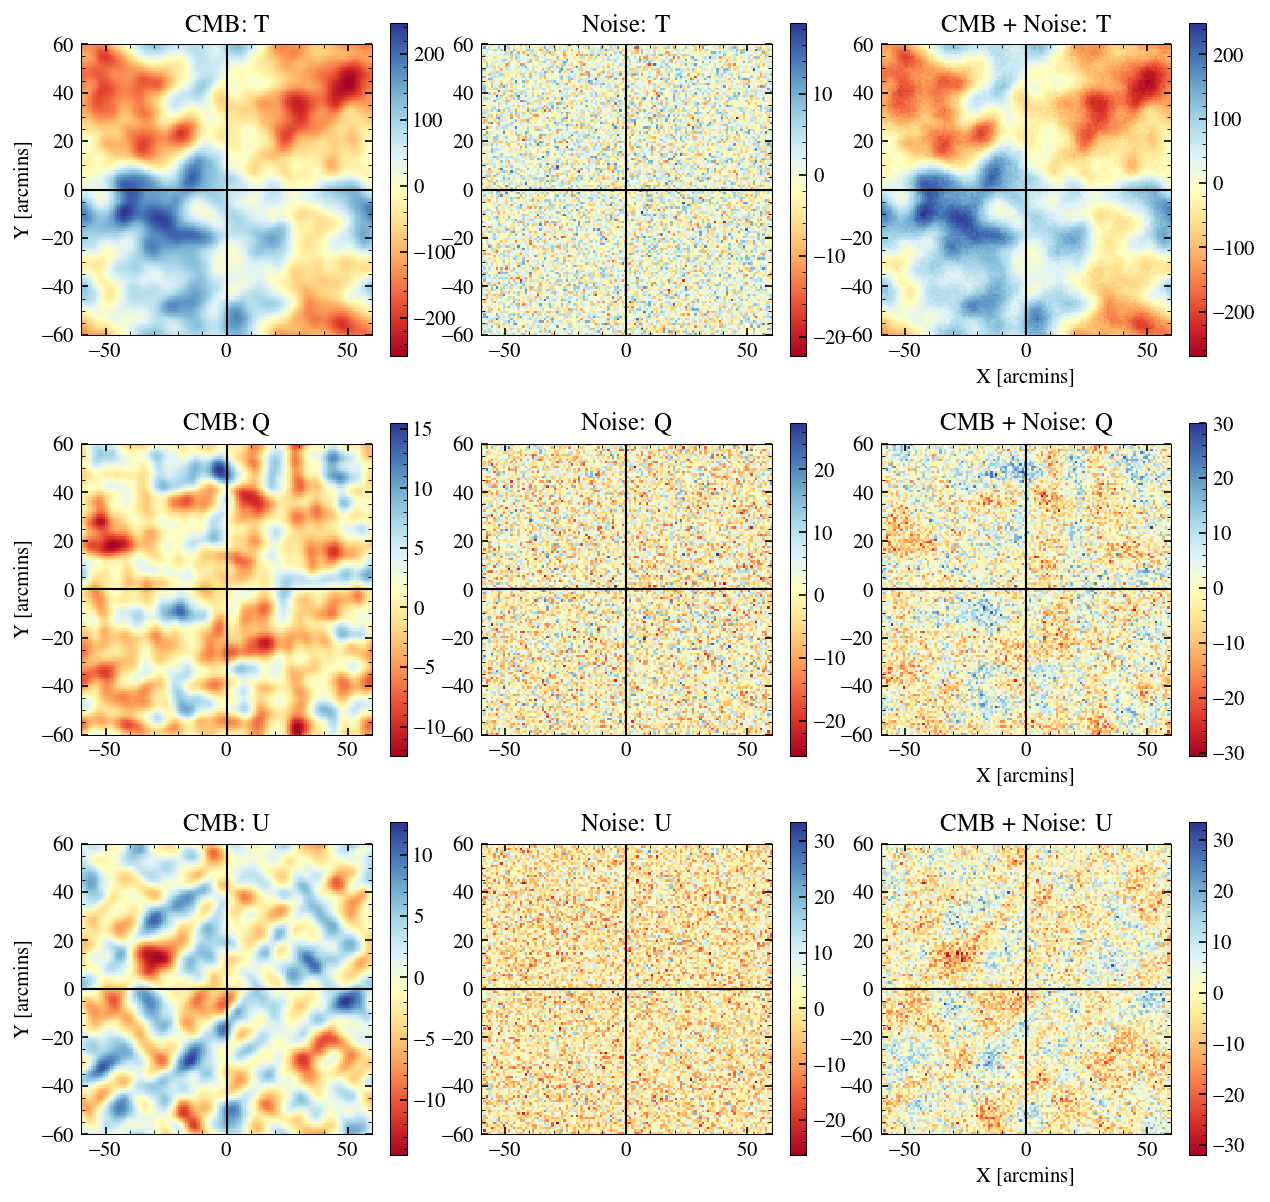

In [26]:
if debug: #just plot the last map
    clf()
    figure(figsize=(10,10))
    subplots_adjust(hspace = 0.2, wspace = 0.1)

    if not pol:
        subplot(131);imshow(cmb_map[0], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB')
        axhline(lw = 1.); axvline(lw = 1.); xlabel(r'X [arcmins]'); ylabel(r'Y [arcmins]')
        subplot(132);imshow(noise_map[0], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Noise')
        axhline(lw = 1.); axvline(lw = 1.); xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
        subplot(133);imshow(sim_map[0], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB + Noise')
        axhline(lw = 1.); axvline(lw = 1.); xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
    else:
        for tqucntr in range(tqulen):
            subplot(3,3,(tqucntr*3)+1);imshow(cmb_map[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB: %s' %(tqu_tit_arr[tqucntr]))
            axhline(lw = 1.); axvline(lw = 1.); ylabel(r'Y [arcmins]')
            subplot(3,3,(tqucntr*3)+2);imshow(noise_map[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Noise: %s' %(tqu_tit_arr[tqucntr]))
            axhline(lw = 1.); axvline(lw = 1.); #xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
            subplot(3,3,(tqucntr*3)+3);imshow(sim_map[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB + Noise: %s' %(tqu_tit_arr[tqucntr]))
            axhline(lw = 1.); axvline(lw = 1.); xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')


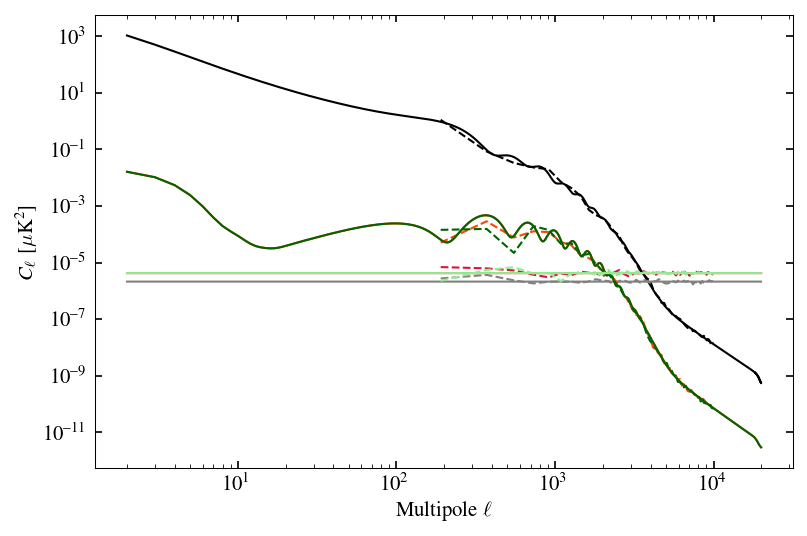

In [27]:
if debug: #get power spectrum of maps to ensure sims are fine
    ax = subplot(111, xscale = 'log', yscale = 'log')
    colorarr = ['black', 'orangered', 'darkgreen']
    colorarr_noise = ['gray', 'crimson', 'lightgreen']
    cl_theory = [cl[0], cl[1]/2, cl[1]/2]
    for tqucntr in range(tqulen):
        curr_el, curr_cl = flatsky.map2cl(mapparams, cmb_map[tqucntr], filter_2d = bl**2.)
        curr_el, curr_nl = flatsky.map2cl(mapparams, noise_map[tqucntr])

        plot(el, cl_theory[tqucntr], color = colorarr[tqucntr])#, label = r'CMB theory')
        plot(curr_el, curr_cl, color = colorarr[tqucntr], ls ='--')#, label = r'CMB map')
        plot(el, nl[tqucntr], color = colorarr_noise[tqucntr])#, label = r'Noise theory')
        plot(curr_el, curr_nl, color = colorarr_noise[tqucntr], ls ='--')#, label = r'Noise map')

    ylabel(r'$C_{\ell}$ [$\mu$K$^{2}$]')
    xlabel(r'Multipole $\ell$')

In [28]:
#get gradient information for all cluster cutouts
if apply_wiener_filter:
    if pol:
        cl_signal_arr = [cl[0], cl[1], cl[1]]
        cl_noise_arr = [nl[0], nl[1], nl[1]]
    else:
        cl_signal_arr = [cl[0]]
        cl_noise_arr = [nl[0]]

#get median gradient direction and magnitude for all cluster cutouts + rotate them along median gradient direction.
ey1, ey2, ex1, ex2 = tools.extract_cutout(mapparams, cutout_size_am)
cutouts_rotated_arr = []
grad_mag_arr = []
for i in tqdm(range(total_clusters)):
    tmp_grad_mag_arr = []
    tmp_cutouts_rotated = []
    for tqu in range(tqulen):
        cutout_grad, grad_orientation, grad_mag = tools.get_gradient(sim_arr[i][tqu], mapparams = mapparams, apply_wiener_filter = apply_wiener_filter, cl_signal = cl_signal_arr[tqu], cl_noise = cl_noise_arr[tqu], lpf_gradient_filter = lpf_gradient_filter, cutout_size_am_for_grad = cutout_size_am_for_grad)
        
        cutout = sim_arr[i][tqu][ey1:ey2, ex1:ex2]
        cutout_rotated = tools.rotate_cutout( cutout, np.median(grad_orientation) )

        tmp_cutouts_rotated.append( cutout_rotated )
        tmp_grad_mag_arr.append( np.median(grad_mag) )
    
    grad_mag_arr.append( np.asarray(tmp_grad_mag_arr) )
    cutouts_rotated_arr.append( np.asarray( tmp_cutouts_rotated ) )

grad_mag_arr = np.asarray(grad_mag_arr)
cutouts_rotated_arr = np.asarray(cutouts_rotated_arr)
print(cutouts_rotated_arr[:, 0].shape)
print(grad_mag_arr.shape)

100%|██████████| 500/500 [00:06<00:00, 75.72it/s]

(500, 20, 20)
(500, 3)


In [29]:
#stack rotated cutouts + apply gradient magnitude weights
weighted_stack = np.sum( cutouts_rotated_arr[:, :] * grad_mag_arr[:, :, None, None], axis = 0)
weights = np.sum( grad_mag_arr, axis = 0)
stack = weighted_stack / weights[:, None, None]
print(weighted_stack.shape, weights.shape)

(3, 20, 20) (3,)


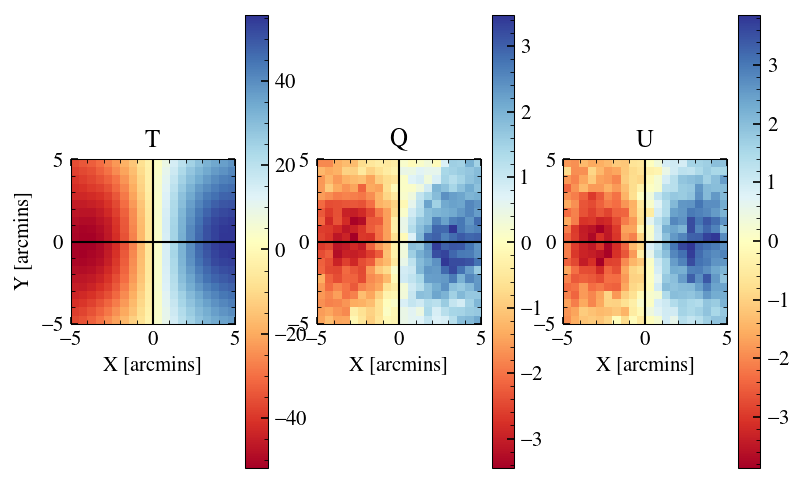

In [30]:
ex1, ex2 = -cutout_size_am/2. * dx, cutout_size_am/2. * dx
for tqu in range(tqulen):
    subplot(1, 3, tqu + 1); imshow(stack[tqu], cmap = cmap, extent = [ex1, ex2, ex1, ex2]); colorbar(); title(r'%s' %(tqu_tit_arr[tqu]))
    axhline(lw = 1.); axvline(lw = 1.)
    xlabel(r'X [arcmins]')
    if tqu == 0: ylabel(r'Y [arcmins]')
show()